## This code was run using the PyTorch 2.4.0 Kernel on Rivanna HPC

Instructions: change dirpath below to the path the (unzipped) Cardiac-Video-Sequence/ directory

In [1]:
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
data = np.load(dirpath+'2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

In [3]:
data[0].keys()

dict_keys(['patient_id', 'cine_mat_filename', 'cine_slice_idx', 'cine_slice_location', 'cine_slice_loc_diff', 'cine_frame_time_stamps', 'cine_lv_myo_masks', 'TOS', 'cine_lv_myo_masks_cropped', 'cine_lv_myo_masks_cropping_box'])

In [4]:
# refactor data
X = []
Y = []
bad_data = []
for entry in data:
    x_i = entry['cine_lv_myo_masks_cropped']
    y_i = entry['TOS']
    
    # Switch from 80,80,25 to 25,80,80
    x_i = np.transpose(x_i, (2, 0, 1))
    
    
    if x_i.shape == (25,80,80):
        X.append(x_i)
        Y.append(y_i)
    else:
        bad_data.append(x_i)

X = np.array(X)
Y = np.array(Y)

In [5]:
(X.shape, Y.shape, len(bad_data))

((113, 25, 80, 80), (113, 126), 15)

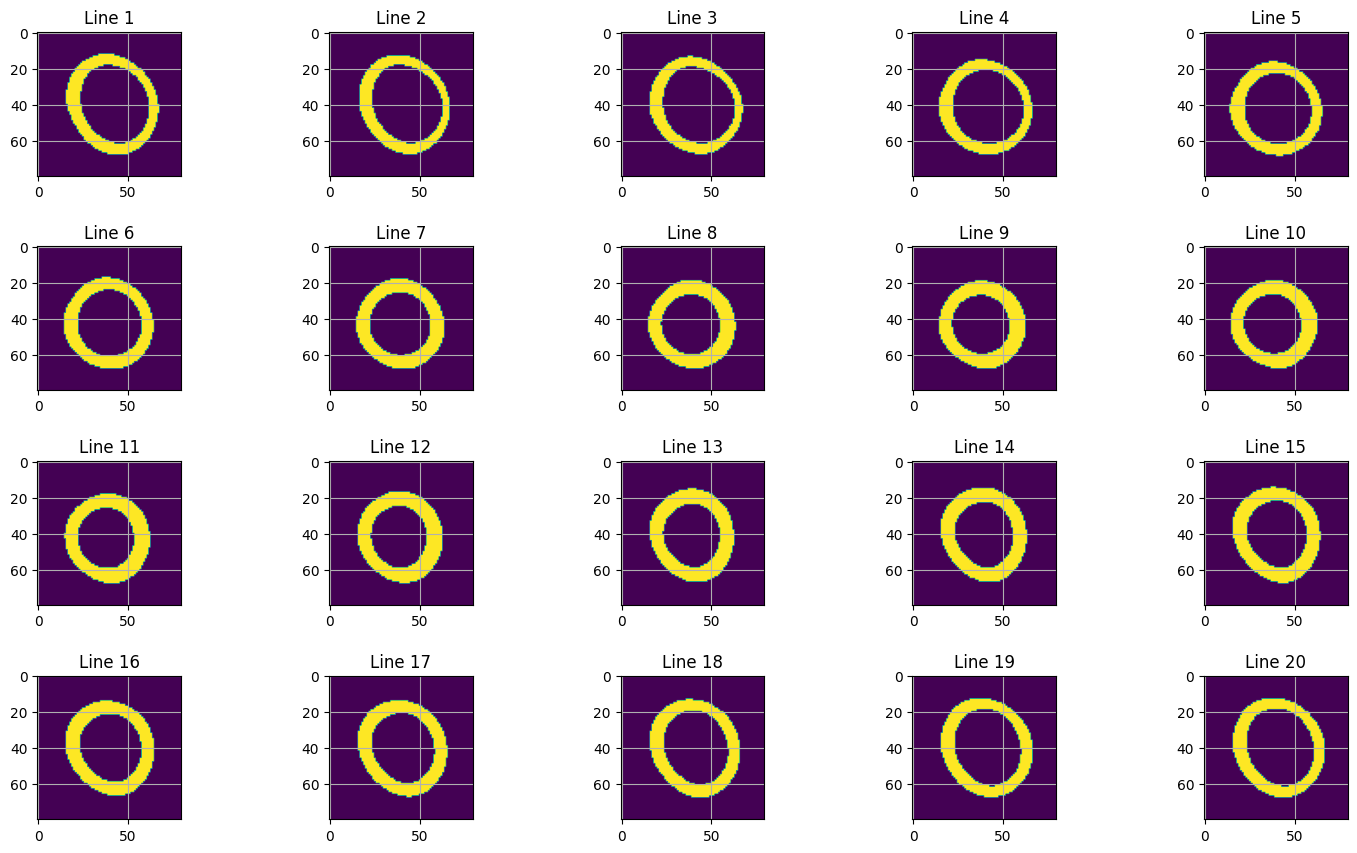

In [6]:
import matplotlib.pyplot as plt

bad_video_sample = bad_data[0]
fig, axes = plt.subplots(4, 5, figsize=(15, 9))  # Adjust figsize as needed
fig.tight_layout(pad=3.0)  # Add padding between subplots

# Plot each line in its respective subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(bad_video_sample[i])
    ax.set_title(f'Line {i+1}')
    ax.grid(True)

# Show the plot
plt.show()

## Data looks fine but is missing 5 frames, we will omit these data

In [7]:
# Remove the flat TOS curves
is_flat = np.all(Y == Y[:, 0][:, np.newaxis], axis=1)

In [8]:
np.sum(is_flat) # Just 1

1

In [9]:
X = X[~is_flat]
Y = Y[~is_flat]

In [10]:
(X.shape, Y.shape)

((112, 25, 80, 80), (112, 126))

In [11]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
torch.save(X_tensor, dirpath+'X_tensor.pt')
torch.save(Y_tensor, dirpath+'Y_tensor.pt')

In [12]:
# Save normalized TOS curves for experimentation
Y_normal = (Y - np.min(Y)) / np.max(Y)
torch.save(Y_tensor, dirpath+'Y_tensor_normal.pt')

In [13]:
# Code to upsample tensor
# Clone original video dataset tensor
videos = X_tensor.clone()

# Add axis for channel dimension
videos = videos.unsqueeze(2)  # Shape becomes (112, 25, 1, 80, 80)
# Repeat the channel dimension for 3 channels
videos = videos.repeat(1, 1, 3, 1, 1)  # Shape becomes (112, 25, 3, 80, 80)

# Reshape for interpolation
N, T, C, H, W = videos.shape  # (112, 25, 3, 80, 80)
videos = videos.view(N * T, C, H, W)  # Shape becomes (112*25, 3, 80, 80)

# Resize the spatial dimensions to 224x224
videos = F.interpolate(videos, size=(224, 224), mode='bilinear', align_corners=False)  # Shape: (112*25, 3, 224, 224)
videos = videos.view(N, T, C, 224, 224)  # Shape becomes (112, 25, 3, 224, 224)

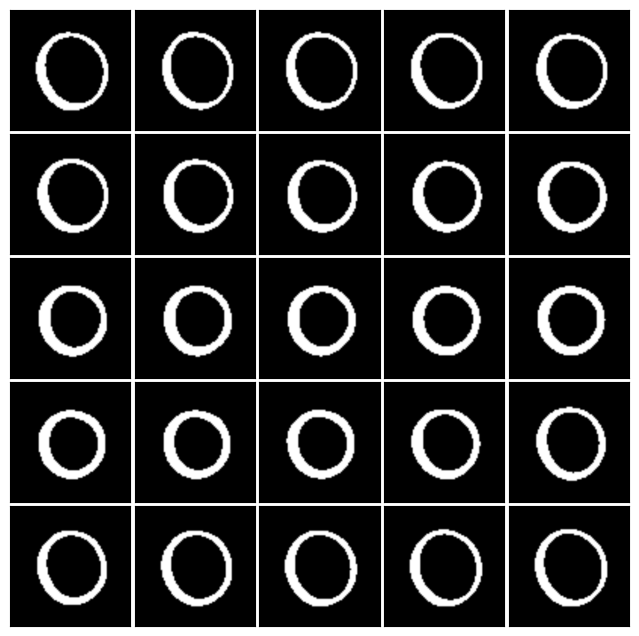

In [14]:
# Code to verify that the upsampled videos look okay
video_sample = videos[100]
fig, axes = plt.subplots(5, 5, figsize=(8, 8))  # Adjust figsize as needed
fig.subplots_adjust(wspace=0.03, hspace=0.03)  # Add padding between subplots

# Plot each line in its respective subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(video_sample[i].permute(1, 2, 0))
    #ax.set_title(f'Line {i+1}')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [15]:
# Save
torch.save(videos, dirpath+'X_upscaled_tensor.pt')

## Figures for the paper

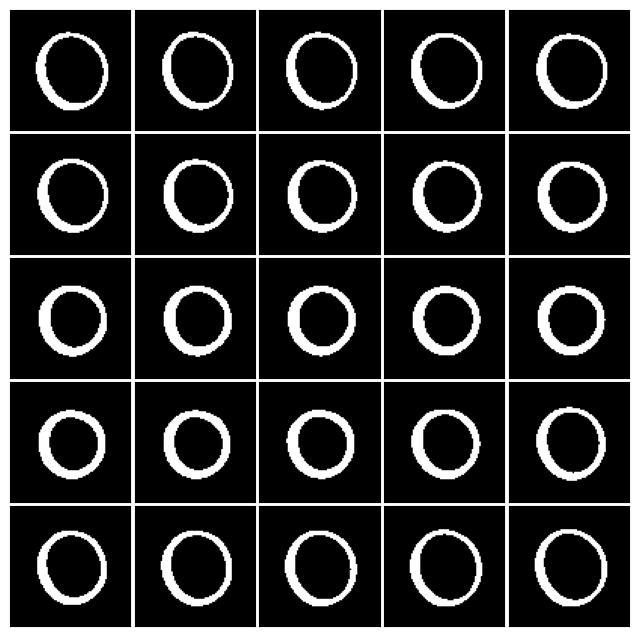

In [16]:
video_sample = X[100]
fig, axes = plt.subplots(5, 5, figsize=(8, 8))  # Adjust figsize as needed
fig.subplots_adjust(wspace=0.03, hspace=0.03)  # Add padding between subplots

# Plot each line in its respective subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(video_sample[i], cmap='gray')
    #ax.set_title(f'Line {i+1}')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig('figs/frames.png')
plt.show()

## Figures for TOS curves / labels
All figures and statistics are calculated after data cleanup

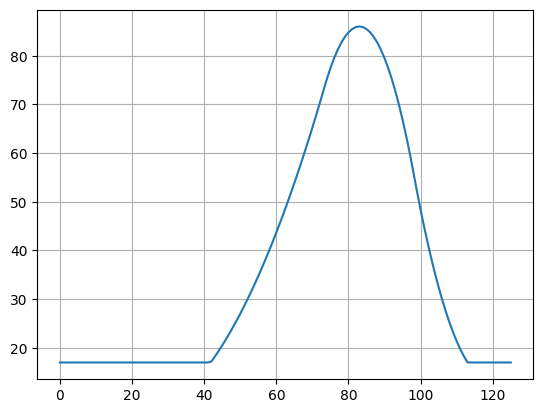

In [17]:
tos_curve = Y[100]

plt.plot(tos_curve)
plt.grid(True)

plt.savefig('figs/tos_curve.png')
plt.show()

In [18]:
# Some stats
len(data)

128

In [19]:
(X.shape, Y.shape)

((112, 25, 80, 80), (112, 126))

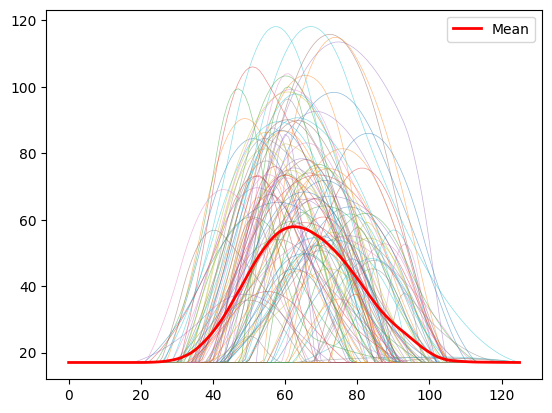

In [20]:
for tos_curve in Y:
    plt.plot(tos_curve, alpha=0.5, linewidth=0.5)
plt.plot(np.mean(Y, axis=0), linewidth=2, label='Mean', color='red')

plt.legend()

plt.savefig('figs/all_curves.png')
plt.show()

In [21]:
peaks = np.max(Y, axis=1)
np.mean(peaks), np.max(peaks), np.min(peaks)

(70.53381221121094, 118.1896796246056, 18.29132907939205)

In [22]:
np.mean(np.mean(X, axis=(1,2,3))) * 100

11.179363839285713

In [23]:
np.mean(np.var(X, axis=(1,2,3)))

0.09785158294363838

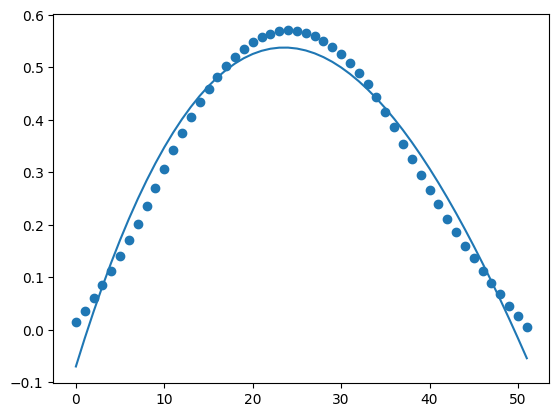

In [24]:
y = Y_normal[0]
y = y[y>0]
x = np.arange(len(y))

mymodel = np.poly1d(np.polyfit(x, y, 3))

plt.scatter(x, y)
plt.plot(x, mymodel(x))
plt.show() 

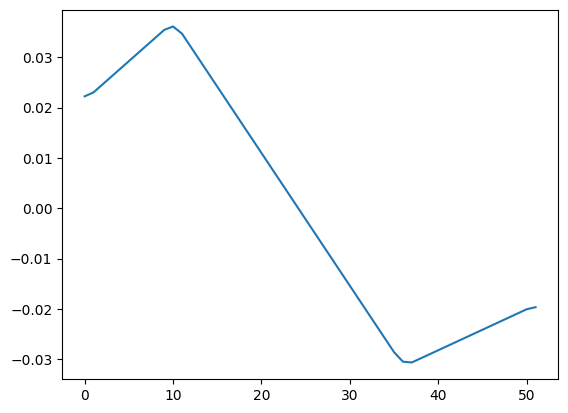

In [25]:
plt.plot(np.gradient(y))